# Explore the per turn, per city, measurements

The per turn, per city data contains the city yields per turn for food, production, gold, science, culture, and faith. It also captures the population, housing, and amenities per turn.

The purpose of this workbook is to determine what a good city looks like. The ultimate goal is to determine a list of good and less than good cities. This list will be the target value of the eventual Machine Learning model.

In [1]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [2]:
cnx = sqlite3.connect('Database/Civ6CitySettledData.db')
cur = cnx.cursor()
#print(cnx)
#print(cur)

## Retrieve the city growth and performance data
The cityPerTurnView in the database contains all the relevant data captured for each city per turn of the game. I align the number of turns the city has existed so we can make elapsed (from settled) turn based comparisons.

The base identity for this database is the cityId. That is, in this database (and experiment) is designed to look at city growth over time. The same cityName can occur in multiple games so when we add the recorded information for the game we create new cityIds.

In [3]:
sqlSelect = 'SELECT * FROM cityPerTurnView WHERE turns >= 1 and turns <= 50'
cityPt = pd.read_sql_query(sqlSelect, cnx)
print(cityPt.shape)
print(cityPt.dtypes)

(25100, 29)
cityId                 int64
gameId                 int64
settledById            int64
currentOwnerId         int64
cityName              object
settledByName         object
settledByCiv          object
currentOwnerName      object
currentOwnerCiv       object
settledOnTurn          int64
gameTurn               int64
turns                  int64
foodPerTurn          float64
foodToolTip           object
productionPerTurn    float64
productionToolTip     object
goldPerTurn          float64
goldToolTip           object
sciencePerTurn       float64
scienceToolTip        object
culturePerTurn       float64
cultureToolTip        object
faithPerTurn         float64
faithToolTip          object
population             int64
housing                int64
amenities              int64
amenitiesNeeded        int64
happiness             object
dtype: object


## Helper functions
**showYieldMetrics** calculates the cumulative yields for the first 50 turns of a city's existance. It then describes the statistics of this city lifetime yield, and finally produces a timeline of cumulative growth of the specified yield.
It also prints out the top and bottom N cities as requested

**showCityGraph** plots the various yields and measurements for the specified cityId over the 50 turns.

**showSideBySideCityGraph** plots 2 city's various yields and measurements over the 50 turns side by side

NB! All these functions assumes the cityPt DataFrame is initialised above.

In [6]:
def showYieldMetrics(yld, topBottomN):
    columnName = "{}PerTurn".format(yld.lower())
    cumulativeDf = cityPt[['cityId', 'turns', columnName]].pivot(index='turns',
                                                                 columns='cityId',
                                                                 values=columnName).cumsum()
    t50 = cumulativeDf.loc[50]

    print("\n{}:-\nsummary statistics:".format(yld))
    print("     max: {:.2f}".format(t50.max()))
    print("     min: {:.2f}".format(t50.min()))
    print("    mean: {:.2f}".format(t50.mean()))
    print("  median: {:.2f}".format(t50.median()))
    print("     std: {:.2f}".format(t50.std()))
    print("\nQuantiles:")
    print(pd.DataFrame(t50.quantile([0, .2, .4, .6, .8, 1])).T)
    print("\n")

    topN = pd.DataFrame(list(zip(list(t50.nlargest(topBottomN).values),
                                list(t50.nlargest(topBottomN).index.values)
                            )
                    ), columns=["{}Total".format(yld.lower()), 'cityId'])
    bottomN = pd.DataFrame(list(zip(list(t50.nsmallest(topBottomN).values),
                                    list(t50.nsmallest(topBottomN).index.values)
                               )
                          ), columns=["{}Total".format(yld.lower()), 'cityId'])
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4)) #, tight_layout=True)

    cumulativeDf.plot(ax=axes[0], kind='line', legend=False, title="{} - Per city".format(yld))
    axes[0].set_xlabel('Turns since settled')
    axes[0].set_ylabel("{} (cumulative)".format(yld))

    t50.plot(ax=axes[1], kind='hist', legend=False, bins=9, title="{} - Histogram of total".format(yld))
    axes[1].set_xlabel("Total {} by turn 50".format(yld))

    t50.plot(ax=axes[2], kind='box', legend=False, title="{} - Boxplot".format(yld), notch=True)
    axes[2].set_xlabel('Distribution at turn 50')

    plt.savefig('Images/{}Graph.png'.format(yld), bbox_inches='tight')
    plt.show()
    plt.close()

    # Redefining t50 to be the last per turn rows in the dataframe!
    t50 = cityPt[cityPt['turns'] == 50]
    tCitiesDf = topN.set_index('cityId').join(t50.set_index('cityId'))
    bCitiesDf = bottomN.set_index('cityId').join(t50.set_index('cityId'))

    yld = yld.lower()
    print("\nTop {} {} cities:".format(topBottomN, yld))
    print(tCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                     'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])
    print("\n\nBottom {} {} cities:".format(topBottomN, yld))
    print(bCitiesDf[["{}Total".format(yld), "{}PerTurn".format(yld), 'settledByName', 
                     'population', 'housing', 'happiness', "{}ToolTip".format(yld)]])

yldColourDict = {'foodPerTurn': '#A6E64A',
                 'productionPerTurn': '#C78733',
                 'goldPerTurn': '#E8D600',
                 'sciencePerTurn': '#21BFF7',
                 'culturePerTurn': '#E800E8',
                 'population': '#777777'
                }

    
def showCityGraph(cityId):
    cityData = cityPt[(cityPt.cityId == cityId)]
    cityGraphData = cityData[['turns','foodPerTurn', 'productionPerTurn', 'goldPerTurn', 'sciencePerTurn', 'culturePerTurn', 'population']]
    cityGraphData.set_index('turns', inplace=True)
    
    cityGraphData.plot(kind='line', figsize=(7, 7), color=[yldColourDict.get(x, '#333333') for x in cityGraphData.columns])
    plt.show()
    
def showSideBySideCityGraph(city1Id, city1Title, city2Id, city2Title):
    # Init side by side plot in one figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))#, tight_layout=True)

    # Get first city data
    cityData = cityPt[(cityPt.cityId == city1Id)]
    cityGraphData = cityData[['turns','foodPerTurn', 'productionPerTurn', 'goldPerTurn', 'sciencePerTurn', 'culturePerTurn', 'population']]
    cityGraphData.set_index('turns', inplace=True)
    # Create first city plot
    cityGraphData.plot(ax=axes[0], kind='line', title=city1Title, color=[yldColourDict.get(x, '#333333') for x in cityGraphData.columns])
    axes[0].set_xlabel('Turns since settled')
    axes[0].set_ylabel('Yield (per turn)')

    # Get second city data
    cityData = cityPt[(cityPt.cityId == city2Id)]
    cityGraphData = cityData[['turns','foodPerTurn', 'productionPerTurn', 'goldPerTurn', 'sciencePerTurn', 'culturePerTurn', 'population']]
    cityGraphData.set_index('turns', inplace=True)
    # Create second city plot
    cityGraphData.plot(ax=axes[1], kind='line', title=city2Title, color=[yldColourDict.get(x, '#333333') for x in cityGraphData.columns])
    axes[1].set_xlabel('Turns since settled')
    axes[1].set_ylabel('Yield (per turn)')
    
    plt.show()
    plt.close()


    

## Food


Food:-
summary statistics:
     max: 1098.00
     min: 186.00
    mean: 423.57
  median: 411.00
     std: 134.93

Quantiles:
      0.0    0.2    0.4    0.6    0.8     1.0
50  186.0  307.2  383.0  443.0  520.8  1098.0




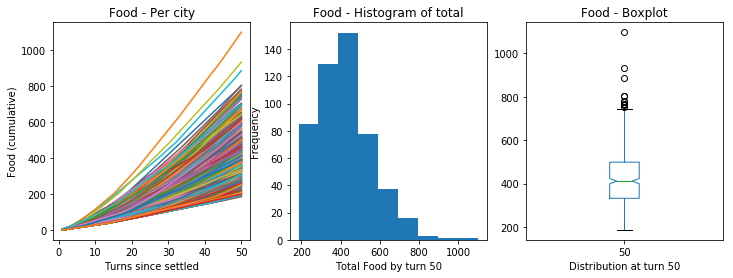


Top 10 food cities:
        foodTotal  foodPerTurn         settledByName  population  housing  \
cityId                                                                      
382        1098.0         29.0       Teddy Roosevelt           7        8   
529         932.0         24.0        Jayavarman VII           7        7   
280         885.0         24.0         Hojo Tokimune           7        7   
206         804.0         22.0  Frederick Barbarossa           7        8   
156         802.0         20.0                Kumasi           7        9   
306         783.0         21.0               Preslav           6        7   
232         774.0         20.0          Chandragupta           6        9   
350         769.0         23.0         Hojo Tokimune           7        8   
352         767.0         23.0             Alexander           7        8   
91          762.0         21.0             Jerusalem           7        8   

         happiness  \
cityId               
382       

In [7]:
showYieldMetrics('Food', 10)

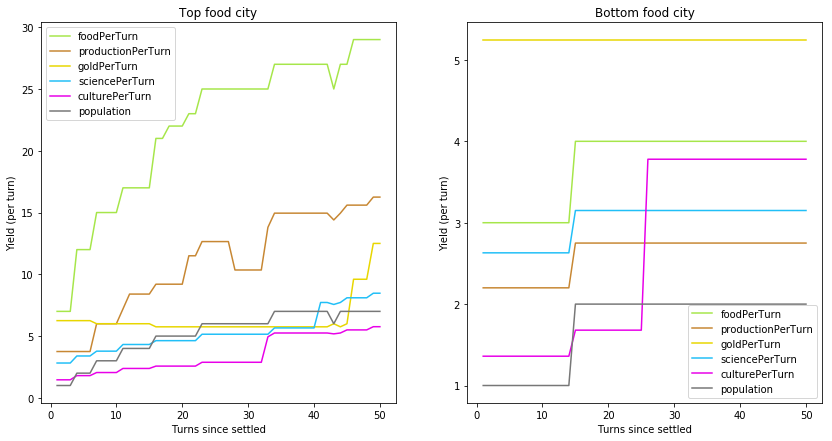

In [8]:
showSideBySideCityGraph(382, 'Top food city', 198, 'Bottom food city')

In [9]:
ser = cityPt[cityPt['cityId'] == 382].foodToolTip.unique()
for r in ser:
    print(r.replace('[NEWLINE]','\n'))
    print('')

+7 from Worked Tiles

+12 from Worked Tiles

+15 from Worked Tiles

+17 from Worked Tiles

+21 from Worked Tiles

+22 from Worked Tiles

+22 from Worked Tiles
+1 from Buildings
   +1 from Granary

+24 from Worked Tiles
+1 from Buildings
   +1 from Granary

+26 from Worked Tiles
+1 from Buildings
   +1 from Granary

+26 from Worked Tiles
+1 from Buildings
   +1 from Granary
+2 from Outgoing Trade Routes



## Production


Production:-
summary statistics:
     max: 768.80
     min: 72.30
    mean: 303.53
  median: 202.88
     std: 189.48

Quantiles:
     0.0    0.2     0.4     0.6     0.8    1.0
50  72.3  138.9  183.45  266.72  509.35  768.8




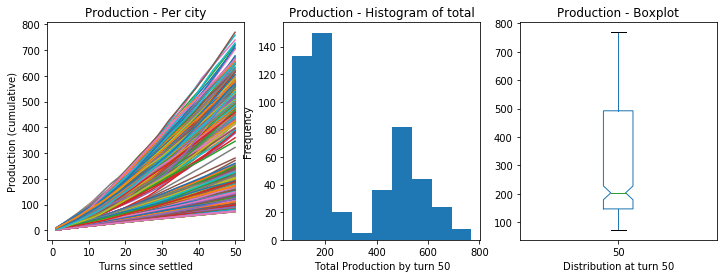


Top 10 production cities:
        productionTotal  productionPerTurn         settledByName  population  \
cityId                                                                         
386              768.80              21.25               Gitarja           5   
250              757.60              18.75                Trajan           4   
132              738.80              16.25              Seondeok           4   
330              726.95              18.00            Poundmaker           3   
83               721.20              17.25  Frederick Barbarossa           5   
471              715.90              21.25       Harald Hardrada           4   
191              707.15              18.00             Alexander           5   
297              702.50              19.55            Poundmaker           5   
381              677.00              20.40           John Curtin           4   
357              673.00              18.75   Catherine de Medici           3   

        hous

In [10]:
showYieldMetrics('Production', 10)

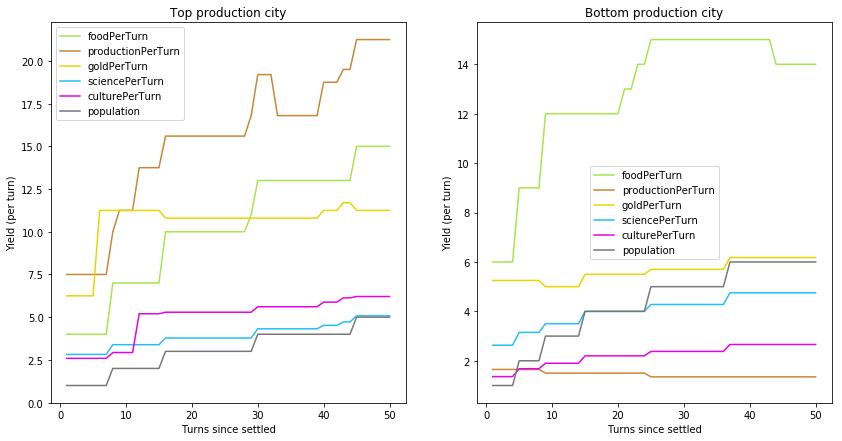

In [11]:
showSideBySideCityGraph(386, 'Top production city', 489, 'Bottom production city')

## Gold


Gold:-
summary statistics:
     max: 885.00
     min: 184.75
    mean: 335.79
  median: 301.38
     std: 105.91

Quantiles:
       0.0     0.2     0.4     0.6     0.8    1.0
50  184.75  257.25  279.47  320.36  387.74  885.0




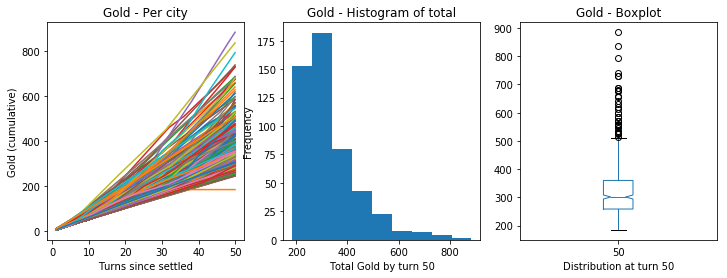


Top 10 gold cities:
        goldTotal  goldPerTurn        settledByName  population  housing  \
cityId                                                                     
355        885.00        25.00            Cleopatra           6       10   
449        837.90        20.40       Jayavarman VII           4        6   
530        794.00        23.75            Cleopatra           5        6   
131        739.30        19.20      Mvemba a Nzinga           5        8   
24         731.20        21.25      Harald Hardrada           2        6   
54         730.20        16.25           Poundmaker           5        6   
23         687.80        16.25             Seondeok           5        7   
25         687.05        21.60               Trajan           5        7   
479        681.65        24.00  Catherine de Medici           6       10   
143        678.45        14.40            Philip II           3        7   

       happiness  \
cityId             
355        Happy   
449   

In [12]:
showYieldMetrics('Gold', 10)

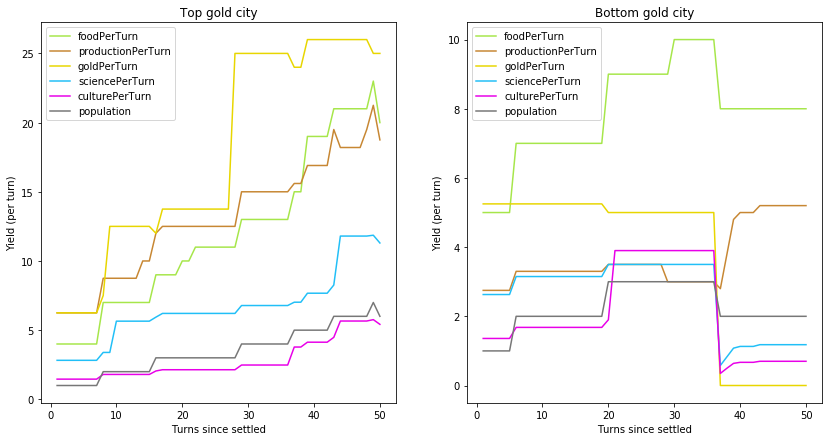

In [13]:
showSideBySideCityGraph(355, 'Top gold city', 402, 'Bottom gold city')

In [14]:
ser = cityPt[cityPt['cityId'] == 355].goldToolTip.unique()
for r in ser:
    print(r.replace('[NEWLINE]','\n'))
    print('')

+5 from Buildings
   +5 from Palace
+20pct (+1) from Modifiers
+5pct (+0.2) from Amenities

+1 from Worked Tiles
+5 from Buildings
   +5 from Palace
+20pct (+1.1) from Modifiers
+5pct (+0.2) from Amenities

+1 from Worked Tiles
+5 from Buildings
   +5 from Palace
+4 from Modifiers
+20pct (+2) from Modifiers
+5pct (+0.5) from Amenities

+1 from Worked Tiles
+5 from Buildings
   +5 from Palace
+4 from Modifiers
+20pct (+2) from Modifiers

+2 from Worked Tiles
+5 from Buildings
   +5 from Palace
+4 from Modifiers
+20pct (+2.1) from Modifiers
+5pct (+0.5) from Amenities

+2 from Worked Tiles
+5 from Buildings
   +5 from Palace
+9 from Outgoing Trade Routes
+4 from Modifiers
+20pct (+4) from Modifiers
+5pct (+1) from Amenities

+2 from Worked Tiles
+5 from Buildings
   +5 from Palace
+9 from Outgoing Trade Routes
+4 from Modifiers
+20pct (+4) from Modifiers

+2 from Worked Tiles
+5 from Buildings
   +5 from Palace
+9 from Outgoing Trade Routes
+4 from Modifiers
+20pct (+4) from Modifiers
+1

## Science


Science:-
summary statistics:
     max: 358.02
     min: 132.07
    mean: 192.41
  median: 182.28
     std: 37.38

Quantiles:
       0.0     0.2      0.4      0.6      0.8     1.0
50  132.07  166.62  176.632  188.588  205.544  358.02




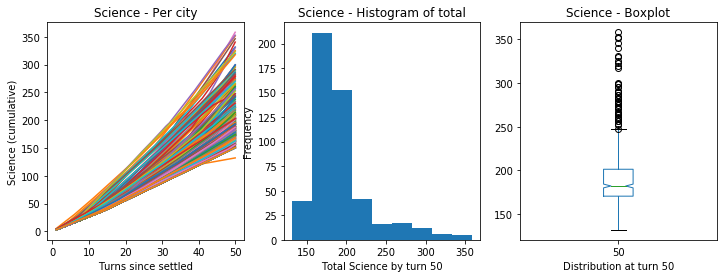


Top 10 science cities:
        scienceTotal  sciencePerTurn         settledByName  population  \
cityId                                                                   
132           358.02           11.30              Seondeok           4   
475           352.61            9.04            Poundmaker           4   
192           351.23            9.18               Jadwiga           5   
206           346.27            9.78  Frederick Barbarossa           7   
159           340.31           12.96             Gilgamesh           6   
71            331.38            8.47             Gilgamesh           3   
355           330.26           11.30             Cleopatra           6   
352           325.19            8.75             Alexander           7   
509           322.98            7.34               Lautaro           3   
220           319.62            7.91                 Gorgo           4   

        housing   happiness  \
cityId                        
132           6       Hap

In [15]:
showYieldMetrics('Science', 10)

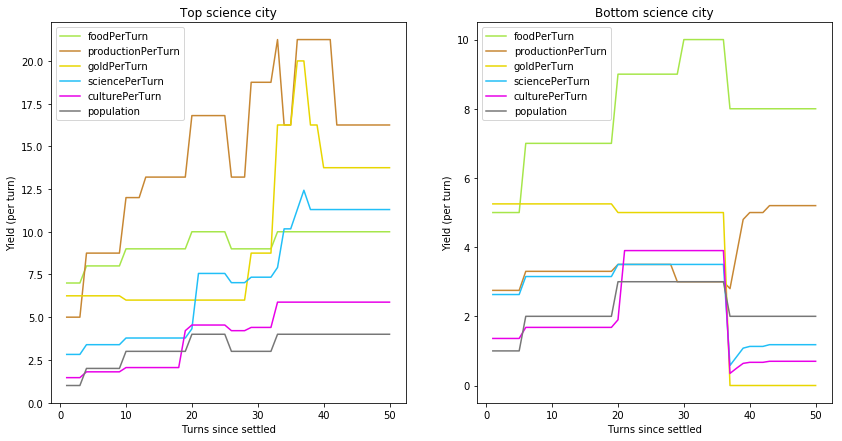

In [16]:
showSideBySideCityGraph(132, 'Top science city', 402, 'Bottom science city')

## Culture


Culture:-
summary statistics:
     max: 369.91
     min: 87.48
    mean: 157.54
  median: 151.48
     std: 42.36

Quantiles:
      0.0      0.2    0.4      0.6      0.8     1.0
50  87.48  129.038  146.8  155.764  175.294  369.91




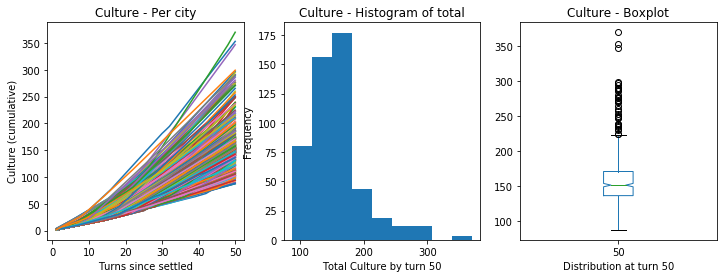


Top 10 culture cities:
        cultureTotal  culturePerTurn    settledByName  population  housing  \
cityId                                                                       
383           369.91           11.80  Mvemba a Nzinga           6        9   
331           352.88            8.75           Trajan           5        7   
265           346.76            9.67          Jadwiga           4        8   
532           299.10            6.66       Poundmaker           3        6   
21            297.01            7.79       Wilhelmina           3        7   
189           294.72            8.92            Shaka           5        8   
51            290.64            7.77  Teddy Roosevelt           4        6   
478           290.29            6.69           Trajan           5        8   
388           289.33            8.53        Amanitore           3        7   
360           288.08            8.13          Gitarja           4        6   

         happiness  \
cityId           

In [17]:
showYieldMetrics('Culture', 10)

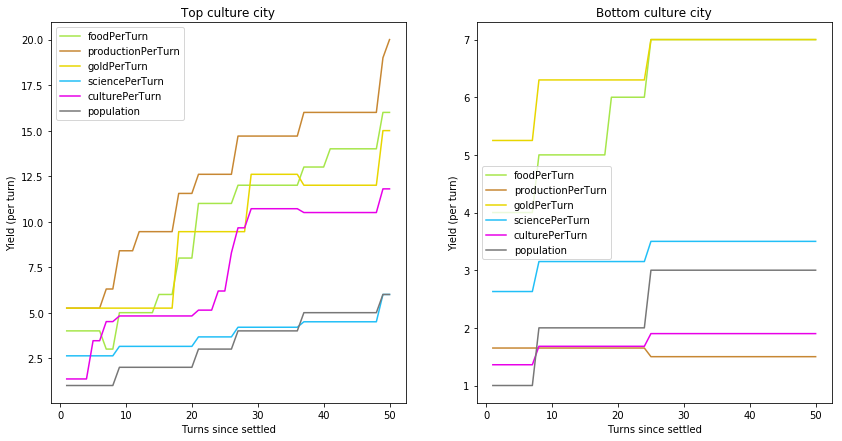

In [18]:
showSideBySideCityGraph(383, 'Top culture city', 311, 'Bottom culture city')

## Faith


Faith:-
summary statistics:
     max: 539.01
     min: 0.00
    mean: 26.59
  median: 0.00
     std: 67.40

Quantiles:
    0.0  0.2  0.4  0.6     0.8     1.0
50  0.0  0.0  0.0  0.0  25.036  539.01




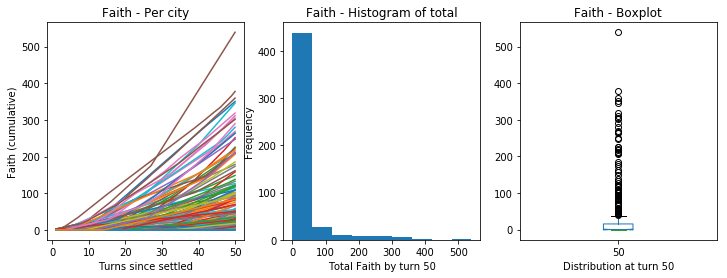


Top 10 faith cities:
        faithTotal  faithPerTurn    settledByName  population  housing  \
cityId                                                                   
161         539.01         15.82            Peter           2        8   
386         377.63         12.43          Gitarja           5        6   
131         359.49          9.72  Mvemba a Nzinga           5        8   
51          350.12          8.64  Teddy Roosevelt           4        6   
280         345.59         11.33    Hojo Tokimune           7        7   
447         318.57          8.64            Gorgo           4        6   
27          311.27         10.17            Cyrus           5        6   
327         305.20          9.72            Peter           4        6   
476         301.31          7.56          Gitarja           5        6   
507         289.73         11.30          Tomyris           3        6   

         happiness  \
cityId               
161          Happy   
386          Happy   
1

In [19]:
showYieldMetrics('Faith', 10)

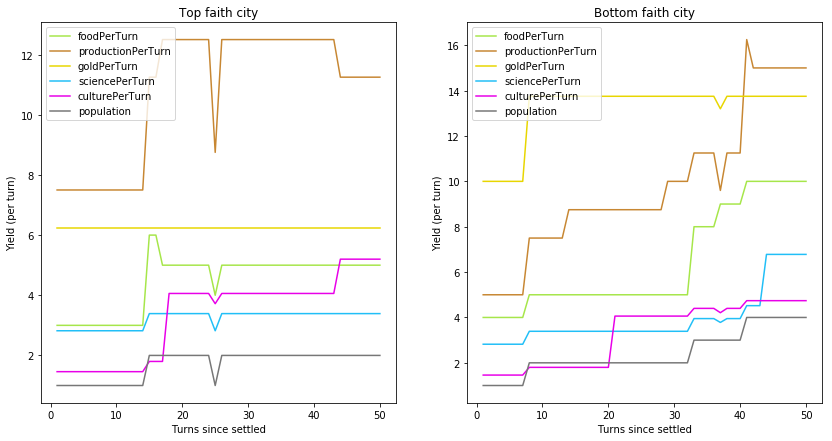

In [20]:
showSideBySideCityGraph(161, 'Top faith city', 2, 'Bottom faith city')

## Population

8
2
4.330677290836653
4.0


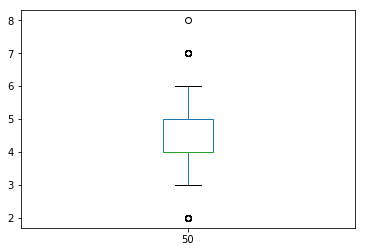

In [21]:
popDf = cityPt[['cityId', 'turns', 'population']].pivot(index='turns',
                                                        columns='cityId',
                                                        values='population')
t50 = popDf.loc[50]

print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box()

In [22]:
# Code testing how to get turn next pop reached
#df = pd.DataFrame({"A": [1,2,2,2,3],
#                   "B": [1,2,2,3,3],
#                   "C": [1,2,3,3,4],
#                   "D": [1,1,1,2,2]}, index=[1,2,3,4,5])
#print(df)
#maxPop = df.max().max()
#newDf = pd.DataFrame(columns=df.columns.values.tolist(), index=range(1,maxPop+1))
#print(newDf)
#
#for i in range(1,maxPop+1):
#    for j in df.columns.values.tolist():
#        s = df[j]
#        try:
#            s = int(s[s == i].index[0])
#        except IndexError:
#            s = 0
#        newDf.loc[i,j] = s
#print(newDf.astype('int64'))

In [23]:
maxPop = popDf.max().max()
popGrowthDf = pd.DataFrame(columns=popDf.columns.values.tolist(), index=range(1, maxPop + 1))
for i in range(1,maxPop+1):
    for j in popDf.columns.values.tolist():
        s = popDf[j]
        try:
            turnNextPopReached = int(s[s == i].index[0])
        except IndexError:
            # Using NaN messes up types so using 0 to indicate never reached that pop!
            turnNextPopReached = 0
        popGrowthDf.loc[i,j] = turnNextPopReached
popGrowthDf = popGrowthDf.T.astype('int64')
print(popGrowthDf.shape)

(502, 8)


In [24]:
print("Population growth descriptive statistics:\n")
print("Columns represent the population, Rows the descriptive measure")
print("count shows the drop-off in number of city with larger population")
popGrowthStats = pd.DataFrame()
for i in popGrowthDf.columns.values.tolist():
    s = popGrowthDf.loc[:,i]
    s = s[s != 0]
    #print(s.describe())
    popGrowthStats[i] = s.describe()
print(popGrowthStats.round(1))

Population growth descriptive statistics:

Columns represent the population, Rows the descriptive measure
count shows the drop-off in number of city with larger population
           1      2      3      4      5     6     7     8
count  502.0  500.0  482.0  397.0  234.0  79.0  19.0   1.0
mean     1.0    8.5   19.9   30.7   37.7  41.5  45.5  46.0
std      0.0    3.2    8.7    9.6    8.3   6.5   3.9   NaN
min      1.0    2.0    6.0   11.0   14.0  23.0  34.0  46.0
25%      1.0    6.0   13.0   23.0   31.2  37.0  44.5  46.0
50%      1.0    8.0   19.0   31.0   39.0  43.0  46.0  46.0
75%      1.0    8.0   21.8   37.0   45.0  47.0  48.5  46.0
max      1.0   15.0   50.0   50.0   50.0  50.0  49.0  46.0


## Housing

12
2
7.272908366533865
7.0


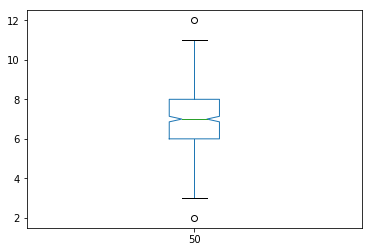

In [25]:
housingDf = cityPt[['cityId', 'turns', 'housing']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='housing')
t50 = housingDf.loc[50]

print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

## Amenities

5
0
1.5099601593625498
1.0


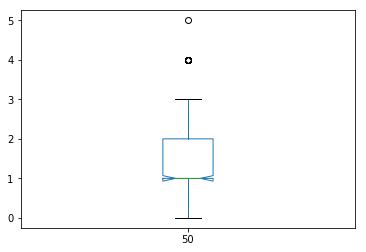

In [26]:
amenitiesDf = cityPt[['cityId', 'turns', 'amenities']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='amenities')
t50 = amenitiesDf.loc[50]
print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

3
0
1.4143426294820718
1.0


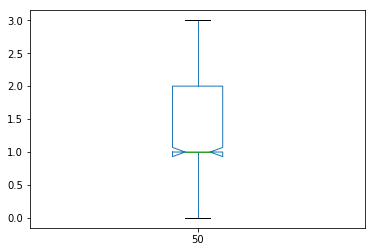

In [27]:
amenitiesNeededDf = cityPt[['cityId', 'turns', 'amenitiesNeeded']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='amenitiesNeeded')
t50 = amenitiesNeededDf.loc[50]
print(t50.max())
print(t50.min())
print(t50.mean())
print(t50.median())

t50.plot.box(notch=True)

## Happiness

In [28]:
happinessDf = cityPt[['cityId', 'turns', 'happiness']].pivot(index='turns',
                                                         columns='cityId',
                                                         values='happiness')
#print(happinessDf.shape)

happinessVals = set([])
for columnName in happinessDf.columns.values.tolist():
    vals = happinessDf[columnName].unique().tolist()
    for item in vals:
        happinessVals.add(item)
#print(happinessVals)

turnsPerHappinessValue = pd.DataFrame()
for columnName in happinessDf.columns.values.tolist():
    for val in happinessVals:
        s = happinessDf[columnName]
        turnsPerHappinessValue.loc[val, columnName] = s[s == val].count()
print("\nPer city number of turns per happiness state:")
print(turnsPerHappinessValue)
print("\nAverage number of turns per happiness state across all the cities:")
print(turnsPerHappinessValue.T.mean())


Per city number of turns per happiness state:
             1     2     3     4     5     6     7     8     9     10   ...   \
Happy       50.0  49.0  15.0  50.0  12.0  20.0  12.0  41.0  34.0  13.0  ...    
Content      0.0   1.0  26.0   0.0  26.0  30.0  38.0   9.0  16.0  24.0  ...    
Ecstatic     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
Displeased   0.0   0.0   9.0   0.0  12.0   0.0   0.0   0.0   0.0  13.0  ...    

             523   524   525   526   527   528   529   530   531   532  
Happy       15.0  50.0  12.0  11.0  16.0  39.0   7.0  34.0  28.0  28.0  
Content     34.0   0.0  34.0  17.0  16.0  11.0  22.0  16.0  22.0   0.0  
Ecstatic     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  22.0  
Displeased   1.0   0.0   4.0  22.0  18.0   0.0  21.0   0.0   0.0   0.0  

[4 rows x 502 columns]

Average number of turns per happiness state across all the cities:
Happy         25.229084
Content       20.282869
Ecstatic       0.167331
Displeased     4.320717

In [29]:
print(cityPt.head())

   cityId  gameId  settledById  currentOwnerId cityName settledByName  \
0       1       1            1               1     Uruk     Gilgamesh   
1       1       1            1               1     Uruk     Gilgamesh   
2       1       1            1               1     Uruk     Gilgamesh   
3       1       1            1               1     Uruk     Gilgamesh   
4       1       1            1               1     Uruk     Gilgamesh   

  settledByCiv currentOwnerName currentOwnerCiv  settledOnTurn    ...     \
0      Sumeria        Gilgamesh         Sumeria              1    ...      
1      Sumeria        Gilgamesh         Sumeria              1    ...      
2      Sumeria        Gilgamesh         Sumeria              1    ...      
3      Sumeria        Gilgamesh         Sumeria              1    ...      
4      Sumeria        Gilgamesh         Sumeria              1    ...      

                                                                                        scienceToolTip  

In [30]:
cur.close()
cnx.close()